https://simpleitk.readthedocs.io/en/master/link_RawImageReading_docs.html#code

In [180]:
import sys
sys.path.append('../')

import SimpleITK as sitk
import os
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from glob import glob

from utils.dataset import read_raw, create_mask, display_two_volumes, min_max_normalization, convert_raw_to_nifti, display_volumes
from utils.logger import pprint_objects
from utils.filemanager import create_directory_if_not_exists

# To allow auto reload to this notebook after modifying any external file imported
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
os.listdir('../rawData/copd1')

['copd1_300_eBH_xyz_r1.txt',
 'copd1_300_iBH_xyz_r1.txt',
 'copd1_eBHCT.img',
 'copd1_iBHCT.img']

In [3]:
copd1_eBHCT = read_raw(
    binary_file_name = "../rawData/copd1/copd1_eBHCT.img",
    image_size = (512, 512, 121),
    sitk_pixel_type = sitk.sitkInt16, # sitk.sitkFloat32
    image_spacing = (0.625, 0.625, 2.5),
    image_origin = (1, 1, 1)
    )

[b'ObjectType = Image\n', b'NDims = 3\n', b'DimSize = 512 512 121\n', b'ElementSpacing = 0.625 0.625 2.5\n', b'Offset = 1 1 1', b'TransformMatrix = 1 0 0 0 1 0 0 0 1\n', b'ElementType = MET_SHORT\n', b'BinaryData = True\n', b'BinaryDataByteOrderMSB = False\n', b'ElementDataFile = C:\\Users\\abdal\\Documents\\Master\\EMJMD MAIA\\SEMESTER 3 - UdG\\MIRA\\4DCT-image-registration\\rawData\\copd1\\copd1_eBHCT.img\n']


In [4]:
copd1_eBHCT

<SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'itk::simple::Image *' at 0x00000289C975F570> >

In [5]:
# sitk.WriteImage(copd1_eBHCT, './raw_modified.nii.gz')

Max intensity 2672
Min intensity -2000
Data type int16
Image shape (512, 512, 121)
0 pixels count 512


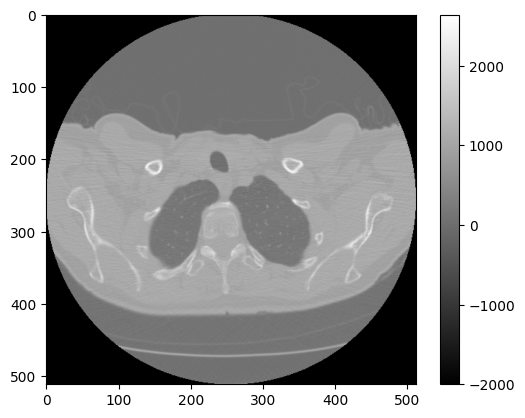

In [6]:
copd1_eBHCT_img = sitk.GetArrayFromImage(copd1_eBHCT)
copd1_eBHCT_img = np.transpose(copd1_eBHCT_img, (1, 2, 0))

print("Max intensity", copd1_eBHCT_img.max())
print("Min intensity", copd1_eBHCT_img.min())
print("Data type", copd1_eBHCT_img.dtype)
print("Image shape", copd1_eBHCT_img.shape)
print("0 pixels count",  len(copd1_eBHCT_img == 0))

plt.imshow(copd1_eBHCT_img[:,:,10], cmap='gray')
plt.colorbar()
plt.show()

The volumes has alot of background pixels that are for backround (both black corners and surrounding of the chest). For us to remove them, we have to create a mask for the volume. This will help us normalize the volumes as a pre-processing before registration.

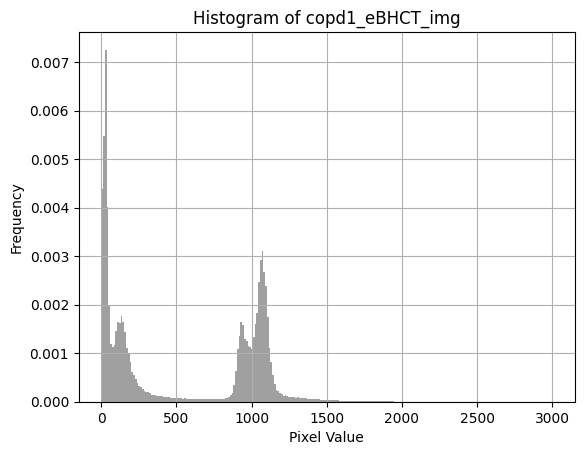

In [7]:
# Flatten the image to a 1D array
flattened_image = copd1_eBHCT_img.ravel()

# Plot the histogram
plt.hist(flattened_image, bins=256, range=(0, 3000), density=True, color='gray', alpha=0.75)
plt.title('Histogram of copd1_eBHCT_img')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

Note that the pixel values with intensity close to -2000 are the background, so we can exclude them from the histogram range. \
Seems like we can take pixel value between [500, 700] as a threshold to separate the two intensities (scan gray background and chest tissues)

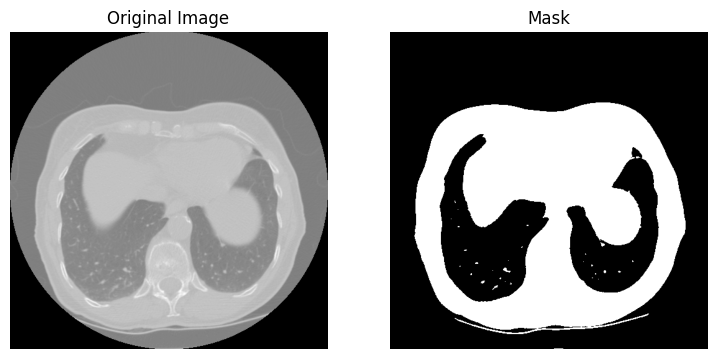

In [100]:
mask = create_mask(copd1_eBHCT_img, threshold=700)

display_two_volumes(copd1_eBHCT_img, mask, 'Original Image', 'Mask', slice=90)

In [13]:
max_int16 = np.iinfo(np.int16).max
print(f"The maximum value for int16 is: {max_int16}")

The maximum value for int16 is: 32767


The maximum value for this volume int16 is: 32767
(512, 512, 121) float64 32767.0 -44902.92592592593


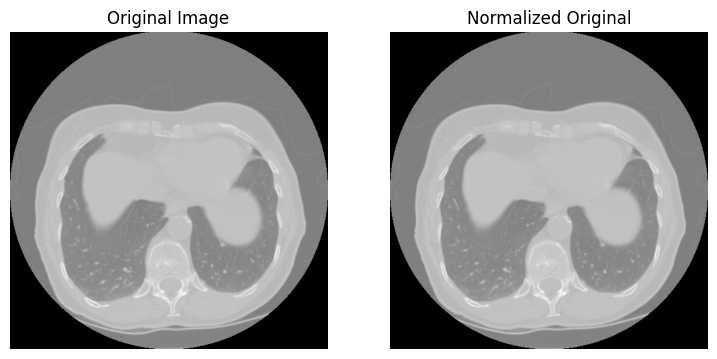

In [101]:
normalized = min_max_normalization(copd1_eBHCT_img, mask=mask)

print(normalized.shape, normalized.dtype, normalized.max(), normalized.min())

display_two_volumes(copd1_eBHCT_img, normalized, 'Original Image', 'Normalized Original', slice=90)

Now explore all data based on those findings...

In [64]:
train_path = '../rawData'

# prepare the paths
exhale_volumes = [path.replace('\\', '/') for path in sorted(glob(os.path.join(train_path, "***" , "*eBHCT.img"), recursive=True))]
inhale_volumes = [path.replace('\\', '/') for path in sorted(glob(os.path.join(train_path, "***" , "*iBHCT.img"), recursive=True))]

In [65]:
exhale_volumes

['../rawData/copd1/copd1_eBHCT.img',
 '../rawData/copd2/copd2_eBHCT.img',
 '../rawData/copd3/copd3_eBHCT.img',
 '../rawData/copd4/copd4_eBHCT.img']

In [117]:
inhale_volumes

['../rawData/copd1/copd1_iBHCT.img',
 '../rawData/copd2/copd2_iBHCT.img',
 '../rawData/copd3/copd3_iBHCT.img',
 '../rawData/copd4/copd4_iBHCT.img']

plot all exhale and enhale volumes side to side

In [182]:
for e_path, i_path in zip(exhale_volumes, inhale_volumes):
    # get file name
    e_filename_full = e_path.split('/')[-1].split('.')[0] #copd1_eBHCT, ..
    i_filename_full = i_path.split('/')[-1].split('.')[0] #copd1_eBHCT, ..

    sample_name = e_path.split('/')[-1].split('_')[0] #copd1, copd2, ...

    # construct output dir
    nifti_path = f'../niftiData/{sample_name}'
    create_directory_if_not_exists(nifti_path)

    # load the dataset dictionary
    with open('../rawData/description.json', 'r') as json_file:
        dictionary = json.loads(json_file.read())
    file_information = dictionary['train'][sample_name]
    
    # read the raw images
    e_image = copd1_eBHCT = read_raw(
        binary_file_name = e_path,
        image_size = tuple(file_information['image_dim']),
        sitk_pixel_type = sitk.sitkInt16,
        image_spacing = tuple(file_information['voxel_dim']),
        image_origin = tuple(file_information['origin'])
        )

    i_image = copd1_eBHCT = read_raw(
        binary_file_name = i_path,
        image_size = tuple(file_information['image_dim']),
        sitk_pixel_type = sitk.sitkInt16,
        image_spacing = tuple(file_information['voxel_dim']),
        image_origin = tuple(file_information['origin'])
        )

    e_image_nifti_path = os.path.join(nifti_path, e_filename_full + ".nii.gz")
    i_image_nifti_path = os.path.join(nifti_path, i_filename_full + ".nii.gz")

    # export niftis for both volumes
    sitk.WriteImage(e_image, e_image_nifti_path)
    sitk.WriteImage(i_image, i_image_nifti_path)

    # get image data and transpose them
    # e_image = sitk.GetArrayFromImage(e_image)  # get the image information
    # e_image = np.transpose(e_image, (1, 2, 0)) # transpose from (Slice, H,W) to (H,W,Slice)

    # i_image = sitk.GetArrayFromImage(i_image)
    # i_image = np.transpose(i_image, (1, 2, 0)) # transpose from (Slice, H,W) to (H,W,Slice)

    # get the masks
    # e_mask =  np.where((e_image <= 700) & (e_image >= 50), 1, 0)
    # e_mask = create_mask(e_image, threshold=700)
    # i_mask = create_mask(i_image, threshold=700)

    # display_volumes(
    #     e_image, 
    #     # e_mask, 
    #     i_image, 
    #     # i_mask, 
    #     title1=f'Exhale {sample_name}', 
    #     # title2=f'Exhale Mask {sample_name}', 
    #     title2=f'Inhale {sample_name}', 
    #     # title4=f'Inhale Mask {sample_name}'
    # )